In [ ]:
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras

In [ ]:
print(tf.__version__)

2.8.2


# 1. Data Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Global Variables
RAW_DATASET_PATH = "/content/drive/MyDrive/Product_Based_Capstone/Team_ML/Raw_Dataset"
CLEAN_DATASET_PATH = "/content/drive/MyDrive/Product_Based_Capstone/Team_ML/Clean_Dataset"
TRAIN_PATH = os.path.join(CLEAN_DATASET_PATH, 'train')
DEV_PATH = os.path.join(CLEAN_DATASET_PATH, 'dev')
# TEST_PATH = os.path.join(DATASET_SPLIT_PATH, 'test')
PLANTS_LIST = os.listdir(RAW_DATASET_PATH)
NUM_OF_PLANTS = len(PLANTS_LIST)

print('Total jenis tanaman herbal:', NUM_OF_PLANTS)

Total jenis tanaman herbal: 18


In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory as IMFD

LABEL_MODE = 'categorical' # Use categorical_crossentropy loss function
COLOR_MODE = 'rgb'
BATCH_SIZE = 32
IMAGE_SIZE = (384, 384)
SEED = 314

train_ds = IMFD(
                  TRAIN_PATH,
                  label_mode=LABEL_MODE,
                  color_mode=COLOR_MODE,
                  batch_size=BATCH_SIZE,
                  image_size=IMAGE_SIZE,
                  seed=SEED,
                )

val_ds = IMFD(
                DEV_PATH,
                label_mode=LABEL_MODE,
                color_mode=COLOR_MODE,
                batch_size=BATCH_SIZE,
                image_size=IMAGE_SIZE,
                seed=SEED,
              )

Found 1679 files belonging to 18 classes.
Found 417 files belonging to 18 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Andong', 'Bayam Duri', 'Binahong', 'Cincau Hijau', 'Jeruk Nipis', 'Kelor', 'Kemangi', 'Kumis Kucing', 'Meniran', 'Mint', 'Pandan', 'Pepaya', 'Sambiloto', 'Sembung', 'Serai', 'Singkong', 'Sirih', 'Talas']


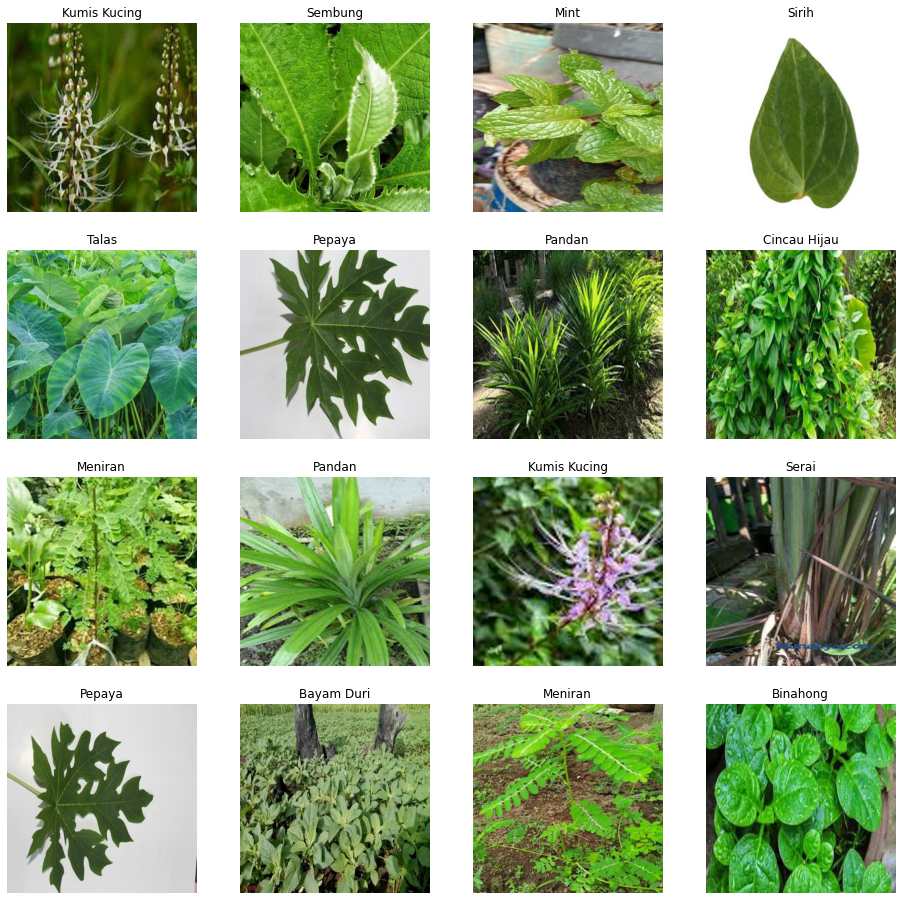

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 16))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_index = np.argmax(labels[i]) # Karena one-hot encoding
    plt.title(class_names[class_index])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 384, 384, 3)
(32, 18)


# B. Building the Model

In [ ]:
# coba EfficientNet_v2 transfer learning
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2S(
                                                                    include_top=False,
                                                                    weights='imagenet',
                                                                    input_shape=(384, 384, 3),
                                                                    include_preprocessing=True
                                                                  )

base_model.trainable = False

82436096/82420632 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "efficientnetv2-s"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 384, 384, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 192, 192, 24  648         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

In [ ]:
print(f"The pretrained model has type: {type(base_model)}")

The pretrained model has type: <class 'keras.engine.functional.Functional'>


In [ ]:
inputs = keras.Input(shape=(384, 384, 3))
x = base_model(inputs, training=False)

# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)

outputs = keras.layers.Dense(NUM_OF_PLANTS, activation='softmax')(x)

model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 384, 384, 3)]     0         
                                                                 
 efficientnetv2-s (Functiona  (None, 12, 12, 1280)     20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 18)                9234  

In [ ]:
model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001), 
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

In [ ]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.995):
      print("\nReached 99.5% accuracy so cancelling training!")
      self.model.stop_training = True

In [ ]:
callbacks = myCallback()

In [ ]:
history = model.fit(train_ds,
                    validation_data = val_ds,
                    epochs = 1,
                    verbose = 1)

53/53 [==============================] - 24s 437ms/step - loss: 0.0151 - accuracy: 0.9976 - val_loss: 0.2630 - val_accuracy: 0.9305


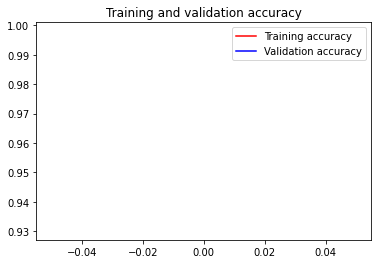

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot the training and validation accuracies for each epoch
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
# Resize data and save on temporary folder
from PIL import Image

def ResizeAndRenameData(source, dest, image_size):
    im = Image.open(source).convert('RGB')
    im.resize(image_size).save(dest)

ResizeAndRenameData('/content/no-brand_no-brand_full03.webp','/content/sambilotomase.jpeg', (384,384))

In [ ]:
# Import the necessary libraries
from numpy import asarray

img = Image.open('/content/sambilotomase.jpeg')
numpydata = asarray(img)
image_array = np.expand_dims(numpydata, axis=0)
print(type(image_array))
print(image_array.shape)

<class 'numpy.ndarray'>
(1, 384, 384, 3)


In [ ]:
pred = model.predict(image_array)

In [ ]:
print(np.argsort(pred))

[[ 9 16  3  2 11 17  7  8 10  1 13  4  6 14  0  5 15 12]]


In [ ]:
sorted = np.argsort(pred)[0]
rank = 18
for top_plants in sorted:
  print('{}. {}'.format(rank, class_names[top_plants]))
  rank -= 1

18. Mint
17. Sirih
16. Cincau Hijau
15. Binahong
14. Pepaya
13. Talas
12. Kumis Kucing
11. Meniran
10. Pandan
9. Bayam Duri
8. Sembung
7. Jeruk Nipis
6. Kemangi
5. Serai
4. Andong
3. Kelor
2. Singkong
1. Sambiloto
